In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import pathlib
import numpy as np

In [30]:
epochs = 100
IMG_SIZE = 96
lr =1e-4
Dropout_rate=0.3
batch_size =128
FREEZE_LR = 1e-4
UNFREEZE_LR = 1e-5

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_root = "/root/autodl-tmp/Aug_Classify"

train_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    train_root,
    shuffle = True,
    batch_size = batch_size,
    image_size=(IMG_SIZE, IMG_SIZE),
    subset = "training",
    seed = 123,
    validation_split = 0.2
)

val_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    train_root,
    shuffle = True,
    batch_size = batch_size,
    image_size=(IMG_SIZE, IMG_SIZE),
    subset="validation",
    seed = 123,
    validation_split=0.2
)
class_names = train_ds.class_names
num_classes = len(class_names)
train_num_images = len(train_ds.file_paths)
val_num_images = len(val_ds.file_paths)
print(class_names)
print(f"num: {num_classes}")
print(f"train imgs: {train_num_images}")
print(f"val imgs: {val_num_images}")

Found 412391 files belonging to 15 classes.
Using 329913 files for training.
Found 412391 files belonging to 15 classes.
Using 82478 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
num: 15
train imgs: 329913
val imgs: 82478


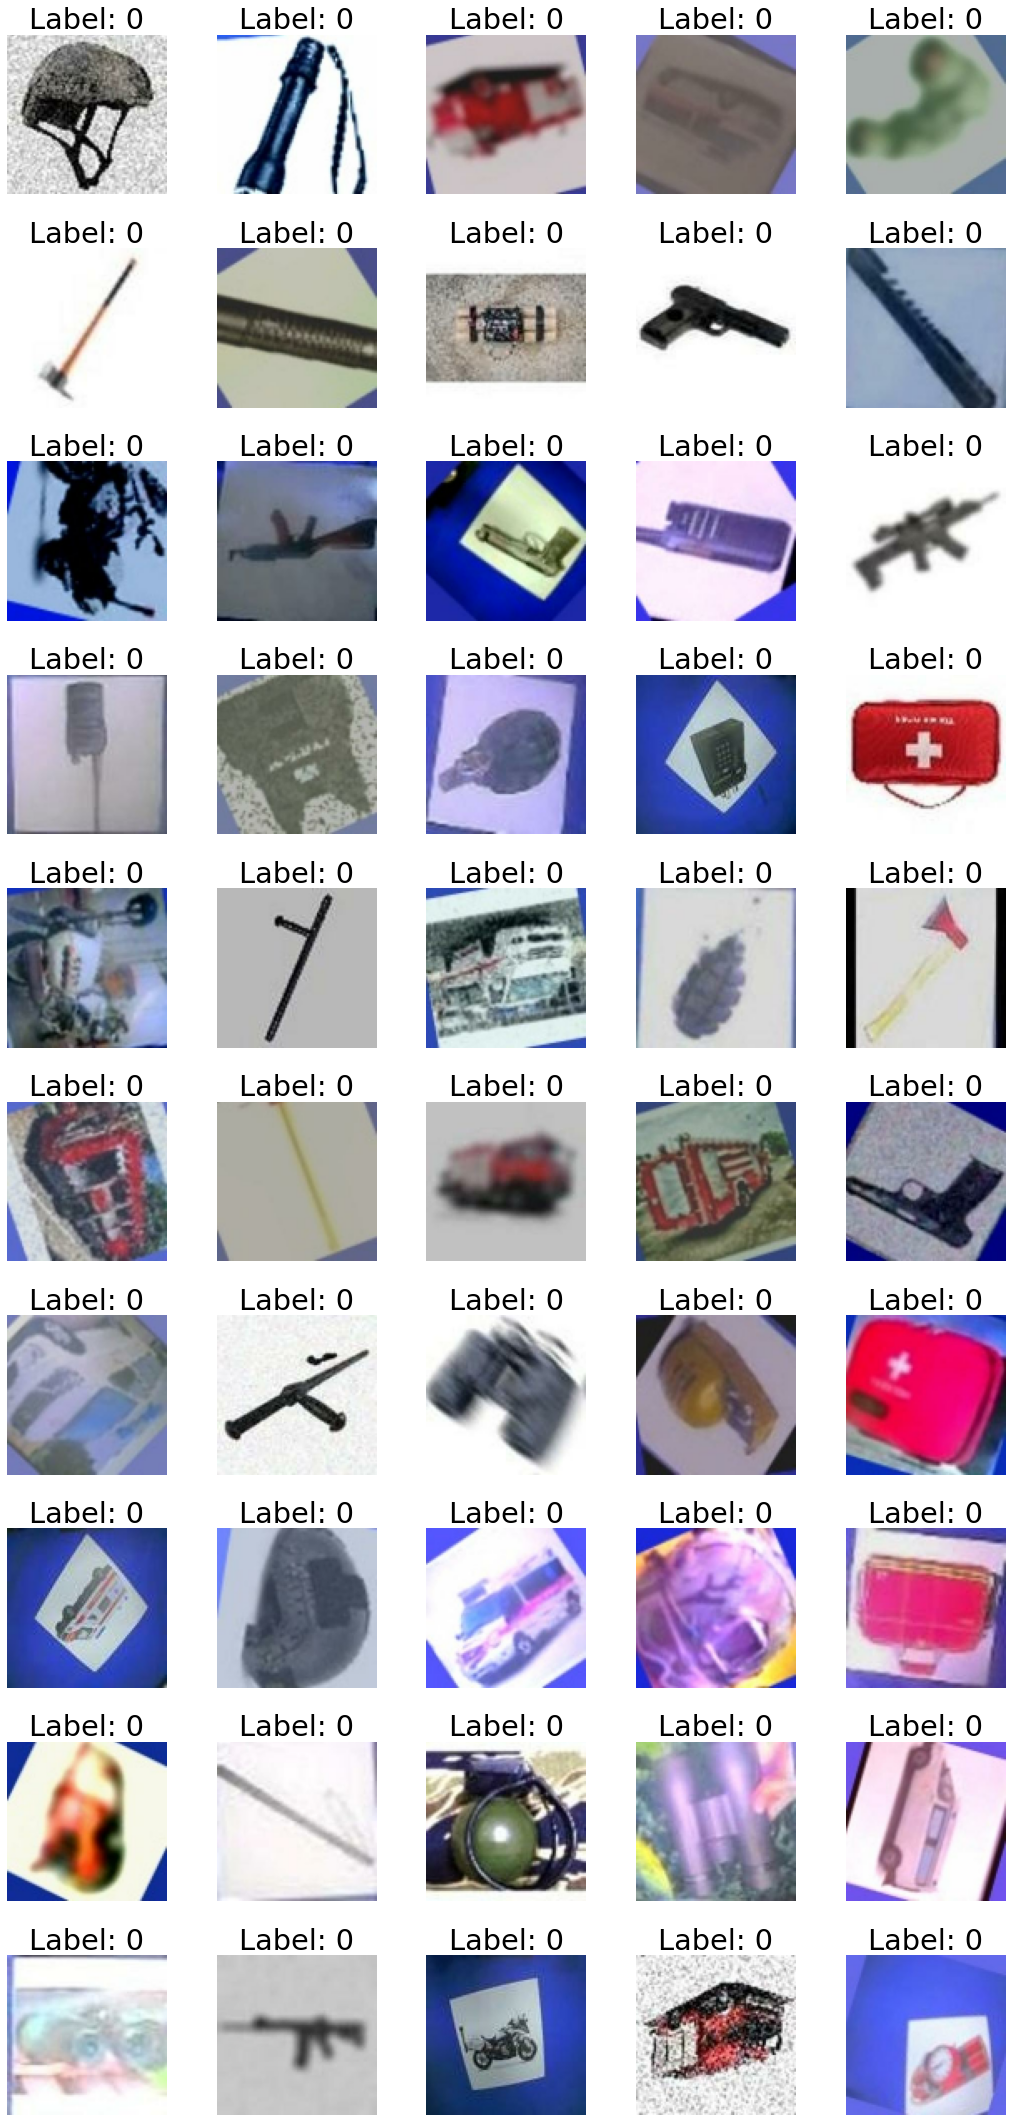

In [32]:
# 获取一个批次的图像和标签
# 获取一个批次的图像和标签
iterator = iter(train_ds)
images, labels = next(iterator)

# 设置要显示的图像数量和布局
num_images_to_display = 50  # 总共要显示的图像数量
images_per_row = 5          # 每行显示的图像数量
rows = (num_images_to_display + images_per_row - 1) // images_per_row  # 计算行数

plt.figure(figsize=(15, rows * 3))

for i in range(num_images_to_display):
    ax = plt.subplot(rows, images_per_row, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))  # 使用 .numpy() 将 Tensor 转换为 NumPy 数组
    plt.title(f"Label: {np.argmax(labels[i])}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [33]:
def _avgpool_dense(image_size: int, num_classes: int, preprocess_input, base_model):
    i = tf.keras.layers.Input([image_size, image_size, 3], dtype=tf.float32, name="input")
    i = preprocess_input(i)
    x = base_model(i)

    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = tf.keras.layers.Dropout(0.2, name="top_dropout")(x)
    x = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return base_model, tf.keras.Model(inputs=[i], outputs=[x], name=base_model.name)

def _get_weight(trainable: bool):
    return None if trainable else "imagenet"

def get_EfficientNetV2B1(image_size: int, num_classes: int, trainable: bool = True):
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
        include_top=False, weights=_get_weight(trainable), input_shape=(image_size, image_size, 3)
    )
    base_model.trainable = trainable
    return _avgpool_dense(image_size, num_classes, tf.keras.applications.efficientnet_v2.preprocess_input, base_model)

In [34]:
base_model, model = get_EfficientNetV2B1(IMG_SIZE, 15, trainable=False)#
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FREEZE_LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

Model: "efficientnetv2-b1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 6,950,339
Trainable params: 19,215


In [35]:
import time
import os
save_path = './efficientNet_save/%s' % (time.strftime('%Y_%m_%d_%H_%M_%S'))

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)
save_weights = tf.keras.callbacks.ModelCheckpoint(save_path + "/model_{epoch:02d}_{val_accuracy:.4f}.h5",
                                                   save_best_only=True, monitor='val_accuracy')
hist = model.fit(train_ds, 
                 epochs=epochs,
                 validation_data=val_ds,
                  callbacks=[save_weights,early_stop,reduce_lr]
                 )

Epoch 1/100
2578/2578 [==============================] - 85s 30ms/step - loss: 1.1110 - accuracy: 0.6936 - val_loss: 0.6323 - val_accuracy: 0.8224 - lr: 1.0000e-04
Epoch 2/100
2578/2578 [==============================] - 76s 30ms/step - loss: 0.6351 - accuracy: 0.8079 - val_loss: 0.4973 - val_accuracy: 0.8532 - lr: 1.0000e-04
Epoch 3/100
2578/2578 [==============================] - 77s 30ms/step - loss: 0.5509 - accuracy: 0.8294 - val_loss: 0.4413 - val_accuracy: 0.8675 - lr: 1.0000e-04
Epoch 4/100
2578/2578 [==============================] - 76s 30ms/step - loss: 0.5118 - accuracy: 0.8393 - val_loss: 0.4090 - val_accuracy: 0.8766 - lr: 1.0000e-04
Epoch 5/100
2578/2578 [==============================] - 79s 31ms/step - loss: 0.4878 - accuracy: 0.8458 - val_loss: 0.3872 - val_accuracy: 0.8829 - lr: 1.0000e-04
Epoch 6/100
2578/2578 [==============================] - 79s 31ms/step - loss: 0.4731 - accuracy: 0.8492 - val_loss: 0.3720 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 7/100
2578

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2578/2578 [==============================] - 79s 30ms/step - loss: 0.4121 - accuracy: 0.8663 - val_loss: 0.3005 - val_accuracy: 0.9054 - lr: 1.0000e-04
Epoch 25/100
2578/2578 [==============================] - 78s 30ms/step - loss: 0.4082 - accuracy: 0.8668 - val_loss: 0.2993 - val_accuracy: 0.9054 - lr: 1.0000e-04
Epoch 26/100
2578/2578 [==============================] - 78s 30ms/step - loss: 0.4094 - accuracy: 0.8663 - val_loss: 0.2980 - val_accuracy: 0.9059 - lr: 1.0000e-04
Epoch 27/100
 691/2578 [=======>......................] - ETA: 46s - loss: 0.4051 - accuracy: 0.8678

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2578/2578 [==============================] - 78s 30ms/step - loss: 0.4062 - accuracy: 0.8669 - val_loss: 0.2902 - val_accuracy: 0.9078 - lr: 1.0000e-04
Epoch 38/100
2578/2578 [==============================] - 77s 30ms/step - loss: 0.4052 - accuracy: 0.8674 - val_loss: 0.2896 - val_accuracy: 0.9079 - lr: 1.0000e-04
Epoch 39/100
2578/2578 [==============================] - 78s 30ms/step - loss: 0.4034 - accuracy: 0.8672 - val_loss: 0.2895 - val_accuracy: 0.9080 - lr: 1.0000e-04
Epoch 40/100
 226/2578 [=>............................] - ETA: 56s - loss: 0.3982 - accuracy: 0.8685

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2578/2578 [==============================] - 78s 30ms/step - loss: 0.4017 - accuracy: 0.8684 - val_loss: 0.2856 - val_accuracy: 0.9090 - lr: 1.0000e-04
Epoch 51/100
2578/2578 [==============================] - 79s 31ms/step - loss: 0.4030 - accuracy: 0.8682 - val_loss: 0.2853 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 52/100
2578/2578 [==============================] - 79s 31ms/step - loss: 0.4026 - accuracy: 0.8674 - val_loss: 0.2853 - val_accuracy: 0.9093 - lr: 1.0000e-04
Epoch 53/100
1277/2578 [=============>................] - ETA: 32s - loss: 0.4032 - accuracy: 0.8683

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2578/2578 [==============================] - 78s 30ms/step - loss: 0.4027 - accuracy: 0.8675 - val_loss: 0.2832 - val_accuracy: 0.9096 - lr: 1.0000e-04
Epoch 64/100
2578/2578 [==============================] - 77s 30ms/step - loss: 0.4033 - accuracy: 0.8673 - val_loss: 0.2831 - val_accuracy: 0.9099 - lr: 1.0000e-04
Epoch 65/100
2578/2578 [==============================] - 78s 30ms/step - loss: 0.3992 - accuracy: 0.8688 - val_loss: 0.2829 - val_accuracy: 0.9101 - lr: 1.0000e-04
Epoch 66/100
1941/2578 [=====================>........] - ETA: 15s - loss: 0.4004 - accuracy: 0.8683

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2578/2578 [==============================] - 79s 31ms/step - loss: 0.4009 - accuracy: 0.8679 - val_loss: 0.2810 - val_accuracy: 0.9104 - lr: 1.0000e-04
Epoch 77/100
2578/2578 [==============================] - 78s 30ms/step - loss: 0.3992 - accuracy: 0.8694 - val_loss: 0.2813 - val_accuracy: 0.9102 - lr: 1.0000e-04
Epoch 78/100
2578/2578 [==============================] - 77s 30ms/step - loss: 0.4013 - accuracy: 0.8681 - val_loss: 0.2809 - val_accuracy: 0.9104 - lr: 1.0000e-04
Epoch 79/100
2371/2578 [==========================>...] - ETA: 5s - loss: 0.4012 - accuracy: 0.8688

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2578/2578 [==============================] - 78s 30ms/step - loss: 0.4008 - accuracy: 0.8686 - val_loss: 0.2804 - val_accuracy: 0.9101 - lr: 1.0000e-04
Epoch 90/100
2578/2578 [==============================] - 78s 30ms/step - loss: 0.4005 - accuracy: 0.8684 - val_loss: 0.2805 - val_accuracy: 0.9103 - lr: 1.0000e-04
Epoch 91/100
2578/2578 [==============================] - 78s 30ms/step - loss: 0.3987 - accuracy: 0.8693 - val_loss: 0.2804 - val_accuracy: 0.9100 - lr: 1.0000e-04
Epoch 92/100
2331/2578 [==========================>...] - ETA: 6s - loss: 0.4012 - accuracy: 0.8686

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



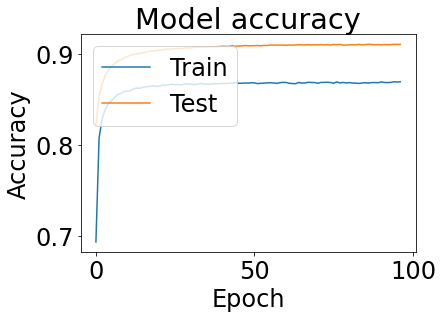

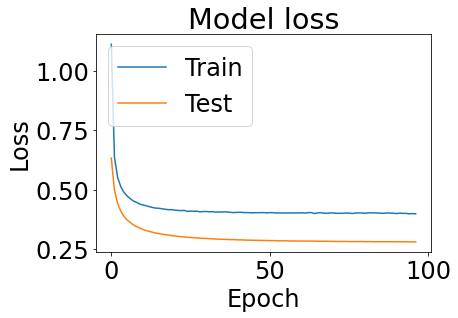

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'{save_path}/acc')

# 绘制训练 & 验证的损失值
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'{save_path}/loss')

df = pd.DataFrame.from_dict(hist.history)
df.to_csv(f'{save_path}/hist.csv', encoding='utf-8', index=False)

In [37]:
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
model.summary()

Model: "efficientnetv2-b1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 6,950,339
Trainable params: 6,808,1

In [38]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=UNFREEZE_LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [39]:
hist = model.fit(train_ds, 
                 epochs=50,
                 validation_data=val_ds,
                  callbacks=[save_weights,early_stop,reduce_lr]
                 )

Epoch 1/50
2578/2578 [==============================] - 212s 76ms/step - loss: 0.1710 - accuracy: 0.9432 - val_loss: 0.0733 - val_accuracy: 0.9756 - lr: 1.0000e-05
Epoch 2/50
 419/2578 [===>..........................] - ETA: 2:30 - loss: 0.0987 - accuracy: 0.9671

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2578/2578 [==============================] - 186s 72ms/step - loss: 0.0247 - accuracy: 0.9916 - val_loss: 0.0219 - val_accuracy: 0.9928 - lr: 1.0000e-05
Epoch 7/50
 488/2578 [====>.........................] - ETA: 2:19 - loss: 0.0203 - accuracy: 0.9928

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2578/2578 [==============================] - 186s 72ms/step - loss: 0.0107 - accuracy: 0.9964 - val_loss: 0.0184 - val_accuracy: 0.9948 - lr: 1.0000e-05
Epoch 12/50
2578/2578 [==============================] - 187s 72ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0184 - val_accuracy: 0.9949 - lr: 1.0000e-05
Epoch 13/50
2578/2578 [==============================] - 187s 72ms/step - loss: 0.0089 - accuracy: 0.9970 - val_loss: 0.0179 - val_accuracy: 0.9953 - lr: 1.0000e-05
Epoch 14/50
2578/2578 [==============================] - 189s 73ms/step - loss: 0.0080 - accuracy: 0.9973 - val_loss: 0.0181 - val_accuracy: 0.9954 - lr: 1.0000e-05
Epoch 15/50
2578/2578 [==============================] - 197s 76ms/step - loss: 0.0075 - accuracy: 0.9975 - val_loss: 0.0178 - val_accuracy: 0.9954 - lr: 1.0000e-05
Epoch 16/50
2578/2578 [==============================] - 195s 76ms/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.0179 - val_accuracy: 0.9953 - lr: 1.0000e-05
Epoch 17/50
2578/2578 

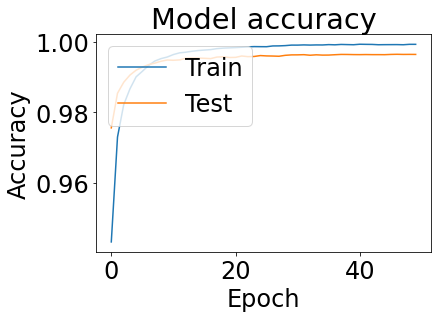

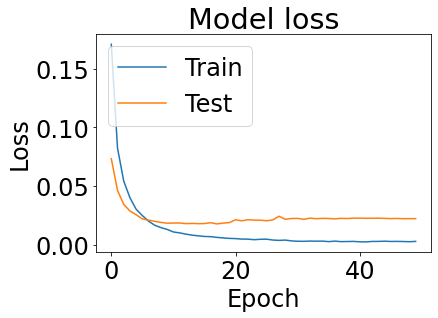

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'{save_path}/acc')

# 绘制训练 & 验证的损失值
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'{save_path}/loss')

df = pd.DataFrame.from_dict(hist.history)
df.to_csv(f'{save_path}/hist.csv', encoding='utf-8', index=False)

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib
font = {'family': 'SimHei', "size": 24}
matplotlib.rc('font', **font)

def get_confusion_matrix(label,y_pred,cls):
    Confusion_Matrix = confusion_matrix(label, y_pred)
    cls_sum = Confusion_Matrix.sum(axis=0)
    Confusion_Matrix = Confusion_Matrix/cls_sum#归一化
    print(np.around(Confusion_Matrix,3))
    Confusion_Matrix=Confusion_Matrix*255
    plt.matshow(Confusion_Matrix, cmap=plt.cm.Greens)
    plt.xlabel('predict')
    plt.ylabel('true')
    xlocations = np.array(range(len(cls)))
    print(cls)
    print(xlocations)
    plt.xticks(xlocations, cls, rotation=0)
    plt.yticks(xlocations, cls)
    plt.show()

In [42]:
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def tflite_pre(modelpath,dataset_root,batch_size=128,input_size = 96):
    test_root = dataset_root

    valid_generator = ImageDataGenerator(validation_split =0.2)
    valid_dataset = valid_generator.flow_from_directory(batch_size=batch_size,
                                                        directory=test_root,
                                                        shuffle=True,
                                                        target_size=(input_size, input_size),
                                                        subset='validation'
                                                       )
    interpreter = tf.lite.Interpreter(model_path=modelpath)

    input_index = interpreter.get_input_details()
    output_index = interpreter.get_output_details()

    acc=0
    sum=0
    labels=np.array([])
    predictions=np.array([])
    with tqdm(valid_dataset,desc='test_tflite') as d:
        for batch_number, (img, label) in enumerate(d):
            batch = len(label)
            label = label.argmax(axis=1)
            sum += batch
            interpreter.resize_tensor_input(input_index[0]['index'], (batch, input_size, input_size, 3))
            interpreter.resize_tensor_input(output_index[0]['index'], (batch, 15))
            interpreter.allocate_tensors()
            interpreter.set_tensor(input_index[0]['index'], np.array(img, dtype=np.int8))
            interpreter.invoke()
            output = interpreter.get_tensor(output_index[0]['index'])
            output = output.argmax(axis=1)
            correct_pre = np.where(output == label, 1, 0)
            acc += correct_pre.sum()

            predictions =np.append(predictions,output)
            labels=np.append(labels,label)

            if sum >= len(valid_dataset) * batch_size:
                break
            d.set_postfix(acc = acc/sum)
            d.update()
    print("小类准确率：", acc / sum)
    get_confusion_matrix(labels,predictions,valid_dataset.class_indices)
    return acc/sum

In [43]:
from tensorflow.keras.models import load_model
import json
import time
import os
def convert_to_tf_lite(model_path,valid_input_size,valid_path=None, convert_data_path = None):
   #  model = load_model(model_path)

    # converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # converter.post_training_quantize=True
    # tflite_model = converter.convert()
#     model = tf.keras.models.load_model(model_path)
#     converter = tf.lite.TFLiteConverter.from_keras_model(model)

#     # 开启动态量化
#     converter.optimizations = [tf.lite.Optimize.DEFAULT]
#     tflite_model = converter.convert()
    train_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
        convert_data_path,
        shuffle = True,
        image_size=(valid_input_size, valid_input_size),
        subset = "validation",
        seed = 123,
        validation_split = 0.2,
    )
    # def representative_dataset():
    #   for data in tf.data.Dataset.from_tensor_slices((images)).batch(1).take(100):
    #     yield [tf.dtypes.cast(data, tf.float32)]
    def representative_data_gen():
        for batch in train_ds.take(500):
            for image in batch[0]:
                # 确认输入形状
                # print(f"Original image shape: {image.shape}")
                reshaped_image = tf.reshape(image, (1, valid_input_size, valid_input_size, 3))
                # print(f"Reshaped image shape: {reshaped_image.shape}")
                yield [reshaped_image]
    model = tf.keras.models.load_model(model_path)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # TFLITE_BUILTINS_INT8
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    tflite_model = converter.convert()
    # TFLite_file.write_bytes(tflite_model)
    
    interpreter = tf.lite.Interpreter(model_content=tflite_model, num_threads=16)
                        
    start_time = time.strftime('%m_%d_%H_%M')
    name = model_path.split('/')[-1][:-3]

    save_root = "./tflite_model/%s_" % start_time +'_' + name
    os.mkdir(save_root)

    save_path = save_root+"/"+str(valid_input_size)+name+'.tflite'

    with open(save_path, 'wb') as f:
        f.write(tflite_model)
    if valid_path!=None:
        acc = tflite_pre(modelpath=save_path,
                         dataset_root=valid_path,
                         input_size=valid_input_size)
        remark = {'model_path':model_path,'input_size':valid_input_size,'valid_path':valid_path,'acc':acc}
        with open(save_root+"/remark.json",'w',encoding='utf-8') as f:
            json.dump(remark,f)

Found 412391 files belonging to 15 classes.
Using 82478 files for validation.


INFO:tensorflow:Assets written to: /tmp/tmpz5xe37gx/assets


INFO:tensorflow:Assets written to: /tmp/tmpz5xe37gx/assets
/root/miniconda3/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2024-08-09 01:46:41.303040: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-08-09 01:46:41.303079: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-08-09 01:46:41.303240: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpz5xe37gx
2024-08-09 01:46:41.367273: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-08-09 01:46:41.367327: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpz5xe37gx
2024-08-09 01:46:41.646134: I tensorflow/cc/saved_model/loader.cc:228

Found 5524 images belonging to 15 classes.


test_tflite: 100%|██████████| 44/44 [01:24<00:00,  1.93s/it, acc=0.73] 

小类准确率： 0.7291224345364473
[[0.644 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.   ]
 [0.    0.252 0.    0.    0.    0.    0.    0.    0.    0.    0.325 0.
  0.    0.    0.   ]
 [0.    0.    0.448 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.   ]
 [0.    0.    0.    0.997 0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.   ]
 [0.    0.    0.056 0.    0.847 0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.002 0.    0.    0.
  0.    0.    0.   ]
 [0.002 0.737 0.331 0.003 0.073 0.    0.9   0.    0.    0.135 0.024 0.
  0.    0.    0.014]
 [0.    0.    0.059 0.    0.    0.    0.    1.    0.    0.    0.    0.
  0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.946 0.    0.004 0.
  0.    0.    0.   ]
 [0.    0.011 0.002 0.    0.    0.    0.007 0.    0.    0.841 0.171 0.
  0.    0.    0.   ]
 [0.019 0.    0.092 0.    0.078 0.    0.093 0.    0.05

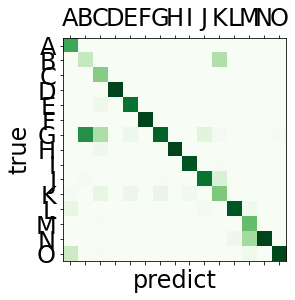

In [44]:
convert_to_tf_lite(model_path='/root/autodl-tmp/17-ai-train-main/efficientNet_save/2024_08_08_20_56_25/model_47_0.9964.h5',
                   valid_input_size=96,
                   valid_path='/root/autodl-tmp/test_openart',
                   convert_data_path="/root/autodl-tmp/Aug_Classify")

In [27]:
new_model = tf.keras.models.load_model('/root/autodl-tmp/17-ai-train-main/models_save/2024_08_08_19_46_45/model_30_0.9994.h5')

# Show the model architecture
new_model.summary()
new_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=UNFREEZE_LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

Model: "efficientnetv2-b1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 6,950,339
Trainable params: 6,808,1

In [28]:
import time
import os
save_path = './efficientNet_save/%s' % (time.strftime('%Y_%m_%d_%H_%M_%S'))

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)
save_weights = tf.keras.callbacks.ModelCheckpoint(save_path + "/model_{epoch:02d}_{val_accuracy:.4f}.h5",
                                                   save_best_only=True, monitor='val_accuracy')
hist = new_model.fit(train_ds, 
                 epochs=epochs,
                 validation_data=val_ds,
                  callbacks=[save_weights,early_stop,reduce_lr]
                 )

Epoch 1/100
2578/2578 [==============================] - 209s 76ms/step - loss: 0.1104 - accuracy: 0.9691 - val_loss: 0.0447 - val_accuracy: 0.9856 - lr: 1.0000e-05
Epoch 2/100
2578/2578 [==============================] - 193s 75ms/step - loss: 0.0506 - accuracy: 0.9837 - val_loss: 0.0330 - val_accuracy: 0.9896 - lr: 1.0000e-05
Epoch 3/100
2578/2578 [==============================] - 192s 75ms/step - loss: 0.0366 - accuracy: 0.9882 - val_loss: 0.0277 - val_accuracy: 0.9910 - lr: 1.0000e-05
Epoch 4/100
2578/2578 [==============================] - 189s 73ms/step - loss: 0.0278 - accuracy: 0.9909 - val_loss: 0.0242 - val_accuracy: 0.9924 - lr: 1.0000e-05
Epoch 5/100
2578/2578 [==============================] - 186s 72ms/step - loss: 0.0229 - accuracy: 0.9924 - val_loss: 0.0232 - val_accuracy: 0.9929 - lr: 1.0000e-05
Epoch 6/100
2578/2578 [==============================] - 186s 72ms/step - loss: 0.0191 - accuracy: 0.9937 - val_loss: 0.0214 - val_accuracy: 0.9935 - lr: 1.0000e-05
Epoch 7/10

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f604fe5c820>
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


KeyboardInterrupt: 